In [1]:
import torch

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel


In [3]:
df=pd.read_csv('/content/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:

df = df.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["label", "message"]
df['label_num']=df['label'].map({
    'ham':0,
    'spam':1
})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [5]:

df_spam = df[df['label']=='spam']

df_ham = df[df['label']=='ham']

print("Ham Dataset Shape:", df_ham.shape)

print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (4825, 3)
Spam Dataset Shape: (747, 3)


# **Balanced Data- BERT+MLP**

In [6]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 3)

In [7]:

df= pd.concat([df_spam , df_ham_downsampled])

In [8]:
df['label_num'].value_counts()

1    747
0    747
Name: label_num, dtype: int64

In [9]:

import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [10]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
def get_bert_embeddings(texts):
    texts = texts.tolist() if isinstance(texts, pd.Series) else texts
    input_ids = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            max_length=128,
            truncation=True,
            add_special_tokens=True,
            return_tensors='pt',
            pad_to_max_length=True
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        outputs = model(input_ids, attention_mask=attention_masks)
        pooled_output = outputs.pooler_output

    return pooled_output



In [12]:
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [14]:
bert_embeddings = get_bert_embeddings(df['message'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
bert_embeddings[0]

tensor([-0.7034, -0.5036, -0.9645,  0.6369,  0.8164, -0.2117,  0.5655,  0.2278,
        -0.7854, -1.0000, -0.4782,  0.8682,  0.9180,  0.6096,  0.6517, -0.4765,
        -0.0743, -0.4411,  0.1959,  0.4396,  0.6187,  1.0000, -0.0987,  0.2161,
         0.4086,  0.9678, -0.5511,  0.6994,  0.8866,  0.4684, -0.2034,  0.3194,
        -0.9646, -0.2305, -0.9728, -0.9781,  0.3996, -0.4282,  0.0270, -0.1062,
        -0.7348,  0.4274,  1.0000, -0.0496,  0.3816, -0.1293, -1.0000,  0.1208,
        -0.6879,  0.9026,  0.8562,  0.9370,  0.2546,  0.4628,  0.4091, -0.1106,
        -0.0454,  0.0222, -0.2772, -0.5921, -0.5642,  0.5834, -0.8998, -0.7532,
         0.9256,  0.9143, -0.3087, -0.4023, -0.1503, -0.0860,  0.5984,  0.2791,
        -0.1890, -0.7416,  0.5376,  0.3169, -0.6651,  1.0000, -0.4166, -0.9130,
         0.9444,  0.8563,  0.5679, -0.5169,  0.7390, -1.0000,  0.5224, -0.2262,
        -0.9647,  0.2703,  0.6167, -0.2807,  0.8622,  0.5676, -0.6756, -0.5301,
        -0.2793, -0.9148, -0.4888, -0.47

In [16]:

X_train, X_test, y_train, y_test = train_test_split(
    bert_embeddings,
    df.label_num,
    test_size=0.2,
    random_state=42
)


In [17]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)

<ipython-input-17-663f12ca6201>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor=torch.tensor(X_train,dtype=torch.float32)


In [18]:
y_train_tensor=torch.tensor(y_train.to_numpy(),dtype=torch.float32)

In [19]:
y_test.value_counts()

0    154
1    145
Name: label_num, dtype: int64

In [20]:
X_test_tensor=torch.tensor(X_test,dtype=torch.float32)


<ipython-input-20-b10cc042634a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor=torch.tensor(X_test,dtype=torch.float32)


In [21]:
y_test_tensor=torch.tensor(y_test.to_numpy(),dtype=torch.float32)

In [22]:
print(y_test_tensor)

tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 1., 

In [23]:
input_size = 768
hidden_size = 512
output_size = 1

mlp_model = MLP(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

In [24]:
criterion.to(device)

BCELoss()

In [25]:
mlp_model.to(device)

MLP(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [26]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

In [27]:
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [28]:
epochs = 100
for epoch in range(epochs):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(X_train_tensor).to(device)
    loss = criterion(outputs.squeeze(), y_train_tensor).to(device)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.6987558007240295
Epoch 2/100, Loss: 0.8445829153060913
Epoch 3/100, Loss: 0.6344292759895325
Epoch 4/100, Loss: 0.7324386239051819
Epoch 5/100, Loss: 0.6614211797714233
Epoch 6/100, Loss: 0.5868731141090393
Epoch 7/100, Loss: 0.5948477387428284
Epoch 8/100, Loss: 0.6004897356033325
Epoch 9/100, Loss: 0.5609601140022278
Epoch 10/100, Loss: 0.523539662361145
Epoch 11/100, Loss: 0.5251269936561584
Epoch 12/100, Loss: 0.5230729579925537
Epoch 13/100, Loss: 0.49274858832359314
Epoch 14/100, Loss: 0.46691593527793884
Epoch 15/100, Loss: 0.463047593832016
Epoch 16/100, Loss: 0.458103746175766
Epoch 17/100, Loss: 0.4369981586933136
Epoch 18/100, Loss: 0.41603606939315796
Epoch 19/100, Loss: 0.40965211391448975
Epoch 20/100, Loss: 0.40452080965042114
Epoch 21/100, Loss: 0.3878270983695984
Epoch 22/100, Loss: 0.37156254053115845
Epoch 23/100, Loss: 0.3653971254825592
Epoch 24/100, Loss: 0.35942763090133667
Epoch 25/100, Loss: 0.34637656807899475
Epoch 26/100, Loss: 0.3352738

In [29]:
 y_test_numpy = y_test_tensor.cpu().numpy()

In [30]:
mlp_model.eval()
with torch.no_grad():
    test_outputs = mlp_model(X_test_tensor)
    predictions = (test_outputs.squeeze() >= 0.5).cpu().float()
    accuracy = accuracy_score(y_test_numpy, predictions)
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.99%


# Trying with new data

In [31]:
sample=pd.read_csv("/content/new.csv.csv",encoding="latin-1")

In [32]:
sample.head()

,Message,Label
0,"Dear Student, Its never too late-clear your ba...",spam
1,Join V-STUDY and score excellent marks in clas...,spam
2,"Join crash courses for B.ST,A/C'S,ECO,ENG,&IP ...",spam
3,CRASH COURSES by BEST POOL OF FACULTY. ENGLISH...,spam
4,"Dear Ola Shuttle user, get 60% Off on your nex...",ham


In [33]:
s_bert_embeddings = get_bert_embeddings(sample['Message'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:

sample['label_num']=sample['Label'].map({
    'ham':0,
    'spam':1
})
sample.head()

,Message,Label,label_num
0,"Dear Student, Its never too late-clear your ba...",spam,1
1,Join V-STUDY and score excellent marks in clas...,spam,1
2,"Join crash courses for B.ST,A/C'S,ECO,ENG,&IP ...",spam,1
3,CRASH COURSES by BEST POOL OF FACULTY. ENGLISH...,spam,1
4,"Dear Ola Shuttle user, get 60% Off on your nex...",ham,0


In [35]:
s_bert_embeddings[0]

tensor([-0.7404, -0.4187, -0.7663,  0.5865,  0.5280, -0.0290,  0.2990,  0.4203,
        -0.2872, -0.9999, -0.0392,  0.6326,  0.9817,  0.3596,  0.6809, -0.1318,
         0.3285, -0.6206,  0.2993,  0.6728,  0.6307,  0.9999,  0.3470,  0.3465,
         0.5044,  0.8668, -0.4992,  0.8461,  0.9159,  0.5942, -0.3155,  0.3458,
        -0.9894, -0.2778, -0.8039, -0.9882,  0.3752, -0.5275, -0.0979,  0.0451,
        -0.8430,  0.4018,  0.9999, -0.4998,  0.4638, -0.2741, -1.0000,  0.2254,
        -0.7735,  0.4480,  0.4250,  0.3735,  0.1315,  0.3174,  0.3065,  0.3676,
        -0.1133,  0.1731, -0.3213, -0.4847, -0.6546,  0.5370, -0.6659, -0.8175,
         0.2632,  0.5116, -0.0981, -0.3718, -0.0628, -0.0066,  0.4014,  0.3752,
         0.0492, -0.8989, -0.1756,  0.3947, -0.4519,  1.0000, -0.0727, -0.9612,
         0.8378,  0.2646,  0.3632,  0.3499,  0.1182, -1.0000,  0.2221, -0.1184,
        -0.9873,  0.2807,  0.4879, -0.2152,  0.7075,  0.3638, -0.3902, -0.4004,
        -0.0890, -0.5248, -0.5509, -0.31

In [36]:
X=torch.tensor(s_bert_embeddings,dtype=torch.float32)

<ipython-input-36-d2a0d459a899>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X=torch.tensor(s_bert_embeddings,dtype=torch.float32)


In [37]:
Y=torch.tensor(sample['label_num'],dtype=torch.float32)

In [38]:
mlp_model.eval()
with torch.no_grad():
    test_outputs = mlp_model(X)
    predictions = (test_outputs.squeeze() >= 0.5).cpu().float()
    accuracy = accuracy_score(Y, predictions)
    print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 82.61%


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report
report=classification_report(Y,predictions)

print(f'Accuracy: {accuracy}\nClassification Report:\n{report}')

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report

conf_matrix = confusion_matrix(Y, predictions)

print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.8260869565217391
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.64      0.75        77
         1.0       0.79      0.96      0.87       107

    accuracy                           0.83       184
   macro avg       0.86      0.80      0.81       184
weighted avg       0.84      0.83      0.82       184

Confusion Matrix:
[[ 49  28]
 [  4 103]]


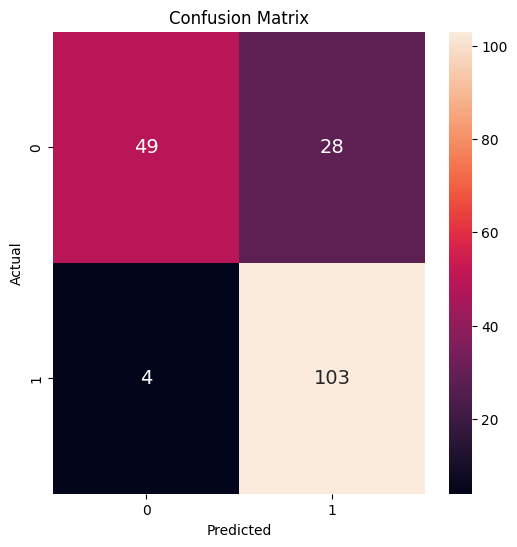

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=True, annot_kws={"size": 14})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()